In [66]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
# nltk.download()

In [3]:
cwd = os.getcwd()

In [25]:
# load data
calendar = pd.read_csv(cwd + '/calendar.csv')
df_list = pd.read_csv(cwd + '/listings.csv')
listings_detail = pd.read_csv(cwd + '/listings_detail.csv')
#neighbourhoods = pd.read_csv(cwd + '/neighbourhoods.csv')
reviews = pd.read_csv(cwd + '/reviews_detail.csv')

/Users/sharonyan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,23603439,2019-07-15,f,$590.00,$590.00,1.0,1125.0
1,23603499,2019-07-15,f,$899.00,$899.00,1.0,1125.0
2,23603499,2019-07-16,f,$899.00,$899.00,1.0,1125.0
3,23603499,2019-07-17,t,$899.00,$899.00,1.0,1125.0
4,23603499,2019-07-18,t,$899.00,$899.00,1.0,1125.0


In [22]:
df_list.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,812,1,92,2019-06-09,0.85,6,347
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68434,117.17231,Private room,1197,1,2,2017-10-08,0.09,4,0
2,114384,Newly Remodeled Apt GUOMAO CBD,533062,Helen,NaN,朝阳区 / Chaoyang,39.90491,116.46367,Entire home/apt,667,1,60,2018-02-14,1.08,4,0
3,114465,"GUOMAO, CBD Comfy Convenient Apt",533062,Helen,NaN,朝阳区 / Chaoyang,39.90441,116.46524,Entire home/apt,619,1,9,2017-09-21,0.11,4,365
4,114475,Cozy Apt Central GUOMAO,533062,Helen,NaN,朝阳区 / Chaoyang,39.90555,116.46695,Entire home/apt,619,1,2,2015-09-26,0.04,4,365


In [28]:
listings_detail.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,44054,https://www.airbnb.com/rooms/44054,20190715155043,2019-07-15,Modern and Comfortable Living in CBD,East Apartments offers comfortable living away...,East Apartments is a western managed serviced ...,East Apartments offers comfortable living away...,none,The neighborhood is a private compound. Just ...,...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.85
1,100213,https://www.airbnb.com/rooms/100213,20190715155043,2019-07-15,The Great Wall Box Deluxe Suite A团园长城小院东院套房,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,This is your guide to live by the Great Wall! ...,none,"5 mins walk to Panglongshan Great Wall, 25 min...",...,t,f,strict_14_with_grace_period,f,f,4,0,3,1,0.09
2,114384,https://www.airbnb.com/rooms/114384,20190715155043,2019-07-16,Newly Remodeled Apt GUOMAO CBD,"华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Our Suite Apartments, located only 40 km from ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,Numerous eateries and coffee store within 3 mi...,...,t,f,moderate,f,f,4,4,0,0,1.08
3,114465,https://www.airbnb.com/rooms/114465,20190715155043,2019-07-15,"GUOMAO, CBD Comfy Convenient Apt","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Warner Beijing Sun Thirsty Apartment, located ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,The neighborhood is quite safe.,...,t,f,moderate,f,f,4,4,0,0,0.11
4,114475,https://www.airbnb.com/rooms/114475,20190715155043,2019-07-15,Cozy Apt Central GUOMAO,"华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...","Warner Beijing Sun Thirsty Apartment, located ...","华纳北京恋日公寓位于北京的中心商务区,是十分受到旅客欢迎的订房选择｡ 5.0 km之外便是市...",none,The neighborhood is very safe and convenient.,...,t,f,moderate,f,f,4,4,0,0,0.04


In [27]:
list(listings_detail)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [23]:
# neighbourhoods

In [24]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t..."
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...


In [15]:
df_list['neighbourhood'].value_counts(normalize=True)

朝阳区 / Chaoyang      0.346208
东城区                 0.110051
海淀区                 0.104584
丰台区 / Fengtai       0.060115
西城区                 0.057585
延庆县 / Yanqing       0.056771
密云县 / Miyun         0.043160
通州区 / Tongzhou      0.041764
顺义区 / Shunyi        0.037110
昌平区                 0.035423
怀柔区 / Huairou       0.033737
大兴区 / Daxing        0.030596
房山区                 0.022481
石景山区                0.008201
门头沟区 / Mentougou    0.006515
平谷区 / Pinggu        0.005700
Name: neighbourhood, dtype: float64

In [16]:
df_list['neighbourhood'].value_counts()

朝阳区 / Chaoyang      11904
东城区                  3784
海淀区                  3596
丰台区 / Fengtai        2067
西城区                  1980
延庆县 / Yanqing        1952
密云县 / Miyun          1484
通州区 / Tongzhou       1436
顺义区 / Shunyi         1276
昌平区                  1218
怀柔区 / Huairou        1160
大兴区 / Daxing         1052
房山区                   773
石景山区                  282
门头沟区 / Mentougou      224
平谷区 / Pinggu          196
Name: neighbourhood, dtype: int64

In [31]:
scores = listings_detail[[#'id',
                          'review_scores_rating', 'review_scores_accuracy', 
                          'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication', 'review_scores_location',
                          'review_scores_value']]

In [52]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34384 entries, 0 to 34383
Data columns (total 7 columns):
review_scores_rating           20199 non-null float64
review_scores_accuracy         20196 non-null float64
review_scores_cleanliness      20196 non-null float64
review_scores_checkin          20189 non-null float64
review_scores_communication    20195 non-null float64
review_scores_location         20181 non-null float64
review_scores_value            20180 non-null float64
dtypes: float64(7)
memory usage: 1.8 MB


In [53]:
scores.dropna(inplace=True)

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


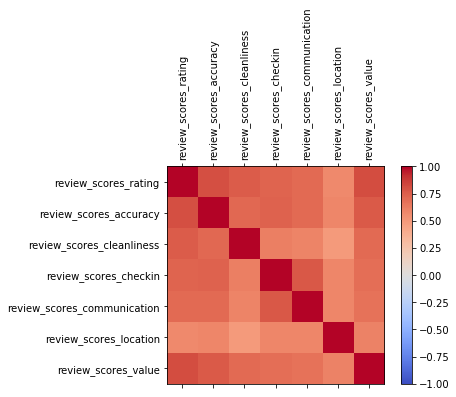

In [54]:
corr = scores.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(scores.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(scores.columns)
ax.set_yticklabels(scores.columns)
plt.show()

## Dig into comments

In [45]:
# step 1: clean data
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240959 entries, 0 to 240958
Data columns (total 6 columns):
listing_id       240959 non-null int64
id               240959 non-null int64
date             240959 non-null object
reviewer_id      240959 non-null int64
reviewer_name    240958 non-null object
comments         240819 non-null object
dtypes: int64(3), object(3)
memory usage: 11.0+ MB


In [47]:
reviews = reviews.dropna(subset=['comments'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240819 entries, 0 to 240958
Data columns (total 6 columns):
listing_id       240819 non-null int64
id               240819 non-null int64
date             240819 non-null object
reviewer_id      240819 non-null int64
reviewer_name    240818 non-null object
comments         240819 non-null object
dtypes: int64(3), object(3)
memory usage: 12.9+ MB


In [62]:
def clean_content(df):
    # filter out symbols
    f = df['comments']
#     r1 = u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'#用户也可以在此进行自定义过滤字符 
    r1 = u'[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(r1,'', f).replace('\n', ' ').replace('\r', '')

In [63]:
reviews['cleaned_comments'] = reviews.apply(clean_content, axis=1)

In [69]:
def is_Chinese(df):
    f = df['comments']
    HZPattern = re.compile(u'[\u4e00-\u9fa5]+')
    return HZPattern.search(f)
reviews['is_Chinese'] = reviews.apply(is_Chinese, axis=1)

In [75]:
reviews_English = reviews[reviews['is_Chinese'].isnull()]

In [76]:
from nltk.corpus import stopwords
def words_bag(df):
    f = df['cleaned_comments']
    stopwords_list = stopwords.words('english')
    return [w for w in f.split(' ') if w not in stopwords_list]
reviews_English['words'] = reviews.apply(words_bag, axis=1)

/Users/sharonyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
neighbourhood_id = df_list[['id', 'neighbourhood']]
reviews_English = reviews_English.merge(neighbourhood_id, how='left', left_on = 'listing_id', right_on = 'id')

In [79]:
reviews_English

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,cleaned_comments,is_Chinese,words,id_y,neighbourhood
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...,Sev was very helpful Sev showed us where to s...,None,"[Sev, helpful, , Sev, showed, us, shop, prices...",44054,朝阳区 / Chaoyang
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...,We arrived in Beijing very early in the mornin...,None,"[We, arrived, Beijing, early, morning, due, de...",44054,朝阳区 / Chaoyang
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...,It is a really massive apartment and really co...,None,"[It, really, massive, apartment, really, comfo...",44054,朝阳区 / Chaoyang
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t...",Sev was incredibly helpful showed us around th...,None,"[Sev, incredibly, helpful, showed, us, around,...",44054,朝阳区 / Chaoyang
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...,The appartment was ideal for our party of adu...,None,"[The, appartment, ideal, party, , adults, spac...",44054,朝阳区 / Chaoyang
5,44054,2439478,2012-09-28,2328151,Ricardo,Nice place to stay when travelling in a group ...,Nice place to stay when travelling in a group ...,None,"[Nice, place, stay, travelling, group, , metro...",44054,朝阳区 / Chaoyang
6,44054,2507676,2012-10-04,3659992,Patrick,We had a great experience in Beijing. The apa...,We had a great experience in Beijing The apar...,None,"[We, great, experience, Beijing, , The, apartm...",44054,朝阳区 / Chaoyang
7,44054,2886867,2012-11-15,3725353,Zahra,The apartment was exactly what I expected (as ...,The apartment was exactly what I expected as p...,None,"[The, apartment, exactly, I, expected, per, pi...",44054,朝阳区 / Chaoyang
8,44054,3722573,2013-03-08,1988718,Petar,Definitely the place to stay when in Beijing. ...,Definitely the place to stay when in Beijing A...,None,"[Definitely, place, stay, Beijing, Apartment, ...",44054,朝阳区 / Chaoyang
9,44054,4447534,2013-05-06,2824806,Emil,We had a great time staying at Sev's apparteme...,We had a great time staying at Sevs appartemen...,None,"[We, great, time, staying, Sevs, appartement, ...",44054,朝阳区 / Chaoyang
